# Sequential DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np
state = env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    #print('state, action, next_state, reward, done, info:', state, action, next_state, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size, hidden_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    cell = tf.nn.rnn_cell.GRUCell(hidden_size)
    #cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell], state_is_tuple=True)
    initial_state = cells.zero_state(batch_size, tf.float32)
    return states, actions, targetQs, cells, initial_state

In [6]:
# RNN generator or sequence generator
def generator(states, action_size, initial_state, cells, hidden_size, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=hidden_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size and
        # static means can NOT adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, hidden_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cells, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state)
        outputs = tf.reshape(outputs_rnn, [-1, hidden_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=action_size)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [7]:
def model_loss(action_size, hidden_size, states, cells, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cells=cells, initial_state=initial_state, 
                                            hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [8]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize MLP/CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    # # Optimize RNN
    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cells, self.initial_state = model_input(
                state_size=state_size, hidden_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cells=cells, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [10]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)
        self.rates = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [95]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 4*2               # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e3)            # memory capacity - 1000 DQN
batch_size = int(1e2)             # experience mini-batch size - 20 DQN
gamma = 0.99                 # future reward discount

In [96]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 8)
(1, ?, 8) (<tf.Tensor 'MultiRNNCellZeroState/GRUCellZeroState/zeros:0' shape=(1, 8) dtype=float32>,)
(1, ?, 8) (<tf.Tensor 'generator/rnn/while/Exit_3:0' shape=(1, 8) dtype=float32>,)
(?, 8)
(?, 2)


In [97]:
model.initial_state[0]

<tf.Tensor 'MultiRNNCellZeroState/GRUCellZeroState/zeros:0' shape=(1, 8) dtype=float32>

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [98]:
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.states.append(np.zeros([1, hidden_size]))
    memory.rates.append(-1)
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/500 # the actual sucess rate of the played sequence
        rate = np.clip(a=rate, a_max=1, a_min=0)
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1: # double-check if it is empty and it is not rated!
                memory.rates[-1-idx] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [99]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append(initial_state[0])
            memory.rates.append(-1) # unrated sequence or episode
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            initial_state = final_state

            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                rate = np.clip(a=rate, a_max=1, a_min=0)
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check if it is empty and it is not rated!
                        memory.rates[-1-idx] = rate # rate each SA pair

            # Training if rated episode available
            rates = np.array(memory.rates)
            maxrates = rates[rates >= np.max(rates)]
            #print(len(maxrates))
            if  len(maxrates) >= batch_size: # 2 rnn states need for states and next states
                initial_states = np.array(memory.states)[rates >= np.max(rates)]
                batch = np.array(memory.buffer)[rates >= np.max(rates)]
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                next_states = np.array([each[2] for each in batch])
                rewards = np.array([each[3] for each in batch])
                dones = np.array([each[4] for each in batch])
                next_actions_logits = sess.run(model.actions_logits, 
                                               feed_dict = {model.states: next_states,
                                                            model.initial_state: initial_states[1]})
                nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
                targetQs = rewards + (gamma * nextQs)
                loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs,
                                                                         model.initial_state: initial_states[0]})
            # End of training
            loss_batch.append(loss)
            if done is True:
                break
                
        # Outputing: priting out/Potting
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 loss:6.5839
Episode:1 meanR:10.0000 R:10.0000 loss:6.5839
Episode:2 meanR:9.6667 R:9.0000 loss:6.5839
Episode:3 meanR:9.7500 R:10.0000 loss:6.5839
Episode:4 meanR:9.6000 R:9.0000 loss:6.5839
Episode:5 meanR:9.6667 R:10.0000 loss:6.5839
Episode:6 meanR:9.5714 R:9.0000 loss:6.5839
Episode:7 meanR:9.5000 R:9.0000 loss:6.5839
Episode:8 meanR:9.5556 R:10.0000 loss:6.5839
Episode:9 meanR:9.6000 R:10.0000 loss:6.5839
Episode:10 meanR:9.5455 R:9.0000 loss:6.5839
Episode:11 meanR:9.5000 R:9.0000 loss:6.5839
Episode:12 meanR:9.4615 R:9.0000 loss:6.5839
Episode:13 meanR:9.4286 R:9.0000 loss:6.5839
Episode:14 meanR:9.4667 R:10.0000 loss:6.5839
Episode:15 meanR:9.4375 R:9.0000 loss:6.5839
Episode:16 meanR:9.4706 R:10.0000 loss:6.5839
Episode:17 meanR:9.4444 R:9.0000 loss:6.5839
Episode:18 meanR:9.4211 R:9.0000 loss:6.5839
Episode:19 meanR:9.4000 R:9.0000 loss:6.5839
Episode:20 meanR:9.4286 R:10.0000 loss:6.5839
Episode:21 meanR:9.3636 R:8.0000 loss:6.5839
Episode:2

Episode:179 meanR:9.1400 R:8.0000 loss:1.1659
Episode:180 meanR:9.1400 R:9.0000 loss:1.1831
Episode:181 meanR:9.1400 R:10.0000 loss:1.2070
Episode:182 meanR:9.1600 R:10.0000 loss:1.2296
Episode:183 meanR:9.1700 R:10.0000 loss:1.2478
Episode:184 meanR:9.1500 R:8.0000 loss:1.2652
Episode:185 meanR:9.1500 R:9.0000 loss:1.2813
Episode:186 meanR:9.1600 R:10.0000 loss:1.3008
Episode:187 meanR:9.1600 R:9.0000 loss:1.3252
Episode:188 meanR:9.1700 R:9.0000 loss:1.3507
Episode:189 meanR:9.1600 R:9.0000 loss:1.3690
Episode:190 meanR:9.1700 R:9.0000 loss:1.3845
Episode:191 meanR:9.1600 R:9.0000 loss:1.3879
Episode:192 meanR:9.1600 R:10.0000 loss:1.4057
Episode:193 meanR:9.1400 R:8.0000 loss:1.4221
Episode:194 meanR:9.1300 R:8.0000 loss:1.4454
Episode:195 meanR:9.1400 R:10.0000 loss:1.4631
Episode:196 meanR:9.1500 R:10.0000 loss:1.4766
Episode:197 meanR:9.1600 R:10.0000 loss:1.4903
Episode:198 meanR:9.1600 R:10.0000 loss:1.5110
Episode:199 meanR:9.1400 R:8.0000 loss:1.5292
Episode:200 meanR:9.1400 

Episode:367 meanR:9.4000 R:10.0000 loss:1.7431
Episode:368 meanR:9.3900 R:8.0000 loss:1.7431
Episode:369 meanR:9.3800 R:8.0000 loss:1.7431
Episode:370 meanR:9.3700 R:9.0000 loss:1.7431
Episode:371 meanR:9.3800 R:9.0000 loss:1.7431
Episode:372 meanR:9.3800 R:10.0000 loss:1.7431
Episode:373 meanR:9.3900 R:9.0000 loss:1.7431
Episode:374 meanR:9.3900 R:9.0000 loss:1.7431
Episode:375 meanR:9.4000 R:9.0000 loss:1.7431
Episode:376 meanR:9.3900 R:9.0000 loss:1.7431
Episode:377 meanR:9.3800 R:10.0000 loss:1.7431
Episode:378 meanR:9.3800 R:9.0000 loss:1.7431
Episode:379 meanR:9.3800 R:10.0000 loss:1.7431
Episode:380 meanR:9.3800 R:10.0000 loss:1.7431
Episode:381 meanR:9.3800 R:10.0000 loss:1.7431
Episode:382 meanR:9.3700 R:8.0000 loss:1.7431
Episode:383 meanR:9.3700 R:10.0000 loss:1.7431
Episode:384 meanR:9.3800 R:10.0000 loss:1.7431
Episode:385 meanR:9.3700 R:10.0000 loss:1.7431
Episode:386 meanR:9.3600 R:9.0000 loss:1.7431
Episode:387 meanR:9.3600 R:9.0000 loss:1.7431
Episode:388 meanR:9.3500 

Episode:552 meanR:9.3300 R:10.0000 loss:1.7431
Episode:553 meanR:9.3300 R:9.0000 loss:1.7431
Episode:554 meanR:9.3300 R:9.0000 loss:1.7431
Episode:555 meanR:9.3100 R:8.0000 loss:1.7431
Episode:556 meanR:9.2900 R:8.0000 loss:1.7431
Episode:557 meanR:9.2700 R:8.0000 loss:1.7431
Episode:558 meanR:9.2600 R:9.0000 loss:1.7431
Episode:559 meanR:9.2700 R:9.0000 loss:1.7431
Episode:560 meanR:9.2800 R:9.0000 loss:1.7431
Episode:561 meanR:9.2600 R:9.0000 loss:1.7431
Episode:562 meanR:9.2500 R:8.0000 loss:1.7431
Episode:563 meanR:9.2800 R:11.0000 loss:1.7431
Episode:564 meanR:9.2800 R:9.0000 loss:1.7431
Episode:565 meanR:9.2900 R:10.0000 loss:1.7431
Episode:566 meanR:9.2900 R:9.0000 loss:1.7431
Episode:567 meanR:9.2900 R:10.0000 loss:1.7431
Episode:568 meanR:9.2800 R:9.0000 loss:1.7431
Episode:569 meanR:9.2900 R:9.0000 loss:1.7431
Episode:570 meanR:9.3000 R:10.0000 loss:1.7431
Episode:571 meanR:9.2900 R:8.0000 loss:1.7431
Episode:572 meanR:9.2900 R:9.0000 loss:1.7431
Episode:573 meanR:9.3000 R:10

Episode:738 meanR:9.4400 R:10.0000 loss:1.7431
Episode:739 meanR:9.4200 R:8.0000 loss:1.7431
Episode:740 meanR:9.4200 R:9.0000 loss:1.7431
Episode:741 meanR:9.4200 R:10.0000 loss:1.7431
Episode:742 meanR:9.4200 R:10.0000 loss:1.7431
Episode:743 meanR:9.4300 R:10.0000 loss:1.7431
Episode:744 meanR:9.4400 R:9.0000 loss:1.7431
Episode:745 meanR:9.4400 R:10.0000 loss:1.7431
Episode:746 meanR:9.4300 R:9.0000 loss:1.7431
Episode:747 meanR:9.4300 R:9.0000 loss:1.7431
Episode:748 meanR:9.4300 R:9.0000 loss:1.7431
Episode:749 meanR:9.4200 R:9.0000 loss:1.7431
Episode:750 meanR:9.4200 R:9.0000 loss:1.7431
Episode:751 meanR:9.4300 R:9.0000 loss:1.7431
Episode:752 meanR:9.4200 R:10.0000 loss:1.7431
Episode:753 meanR:9.4200 R:9.0000 loss:1.7431
Episode:754 meanR:9.4200 R:9.0000 loss:1.7431
Episode:755 meanR:9.4200 R:9.0000 loss:1.7431
Episode:756 meanR:9.4200 R:9.0000 loss:1.7431
Episode:757 meanR:9.4200 R:10.0000 loss:1.7431
Episode:758 meanR:9.4200 R:9.0000 loss:1.7431
Episode:759 meanR:9.4200 R:

Episode:926 meanR:9.4200 R:10.0000 loss:1.7431
Episode:927 meanR:9.4200 R:9.0000 loss:1.7431
Episode:928 meanR:9.4200 R:9.0000 loss:1.7431
Episode:929 meanR:9.4100 R:9.0000 loss:1.7431
Episode:930 meanR:9.4100 R:9.0000 loss:1.7431
Episode:931 meanR:9.4300 R:10.0000 loss:1.7431
Episode:932 meanR:9.4400 R:10.0000 loss:1.7431
Episode:933 meanR:9.4200 R:8.0000 loss:1.7431
Episode:934 meanR:9.4100 R:9.0000 loss:1.7431
Episode:935 meanR:9.4100 R:10.0000 loss:1.7431
Episode:936 meanR:9.4100 R:8.0000 loss:1.7431
Episode:937 meanR:9.4100 R:9.0000 loss:1.7431
Episode:938 meanR:9.4100 R:10.0000 loss:1.7431
Episode:939 meanR:9.4200 R:10.0000 loss:1.7431
Episode:940 meanR:9.4100 R:9.0000 loss:1.7431
Episode:941 meanR:9.4200 R:10.0000 loss:1.7431
Episode:942 meanR:9.4200 R:9.0000 loss:1.7431
Episode:943 meanR:9.4300 R:10.0000 loss:1.7431
Episode:944 meanR:9.4300 R:9.0000 loss:1.7431
Episode:945 meanR:9.4200 R:9.0000 loss:1.7431
Episode:946 meanR:9.4100 R:8.0000 loss:1.7431
Episode:947 meanR:9.4100 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

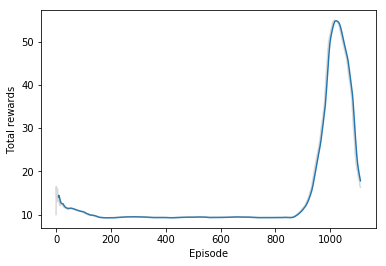

In [94]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

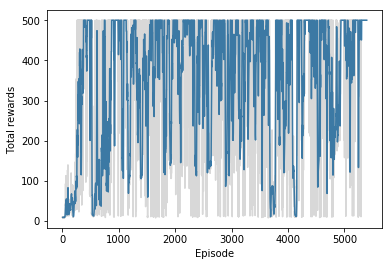

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

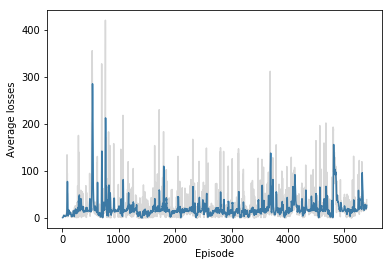

In [23]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episode/epoch
    for _ in range(10):
        total_reward = 0
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.